
The goal of this project is to analyze the shape and kinematics of a nuclear star cluster that has formed from the merger of two supermassive black holes and their respective individual star clusters as simulated by __[Mastrobuono-Battisti et. al (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.6089M/abstract)__.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import corner
from scipy.stats import gaussian_kde

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [125]:
plt.rcParams['text.usetex'] = True

In [2]:
dir = os.getcwd() #path to current working directory 

column_headers = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'm'] #column headers are not included in file
#units in original data file:
#x, y, z: parsecs
#vx, vy, vz: km/s
#m: solar masses

#import data into pandas data frame:
df = pd.read_table(os.path.join(dir,'M5_out_278.00.dat'), names = column_headers) #names option allows manual assigment of column headers


Add new columns:

In [6]:
#add column for the radial distance of the star

df['r'] = (df.x**2 + df.y**2 + df.z**2)**(1/2)

In [7]:
#add column for the speed of the star

df['v'] = (df.vx**2 + df.vy**2 + df.vz**2)**(1/2) 

In [8]:
#add column that indicates whether the row contains a star (True) or a black hole (False)

df['star'] = df.m < 200

In [9]:
#add column to indicate which nuclear star cluster the star/bh originated in

iBH2 = df.loc[df['star'] == 0].index[1] #index of second black hole 
df['nsc'] = (df.index >= iBH2) + 1 

In [10]:
df

,x,y,z,vx,vy,vz,m,r,v,star,nsc
0,-18.206940,1.048421,0.377924,-288.633400,93.939710,9.444297,1000000.0000,18.241016,303.682570,False,1
1,-18.359090,-7.793006,-22.969710,-9.956702,-38.537820,-34.352350,152.5879,30.420301,52.577404,True,1
2,-20.737330,-1.065200,-0.677657,20.406420,-43.044410,-24.544950,152.5879,20.775724,53.588224,True,1
3,-28.424980,25.631390,-3.274062,-14.425630,-50.907200,11.449230,152.5879,38.414413,54.136186,True,1
4,-19.185520,12.413090,1.553668,-36.114180,-47.119080,-17.487140,152.5879,22.903774,61.888947,True,1
...,...,...,...,...,...,...,...,...,...,...,...
131069,-19.790940,6.871008,-5.007380,-49.944390,-68.147930,45.973740,152.5879,21.539868,96.188187,True,2
131070,-175.383900,295.630600,-213.239900,-8.005154,-30.529960,-5.690909,152.5879,404.509850,32.070974,True,2
131071,-6.458676,9.193632,-10.842540,-25.933440,3.228664,1.104360,152.5879,15.614033,26.156972,True,2
131072,-20.141900,1.598176,8.706438,-77.156170,-84.107800,-38.799460,152.5879,22.001190,120.551212,True,2


Corner plot:

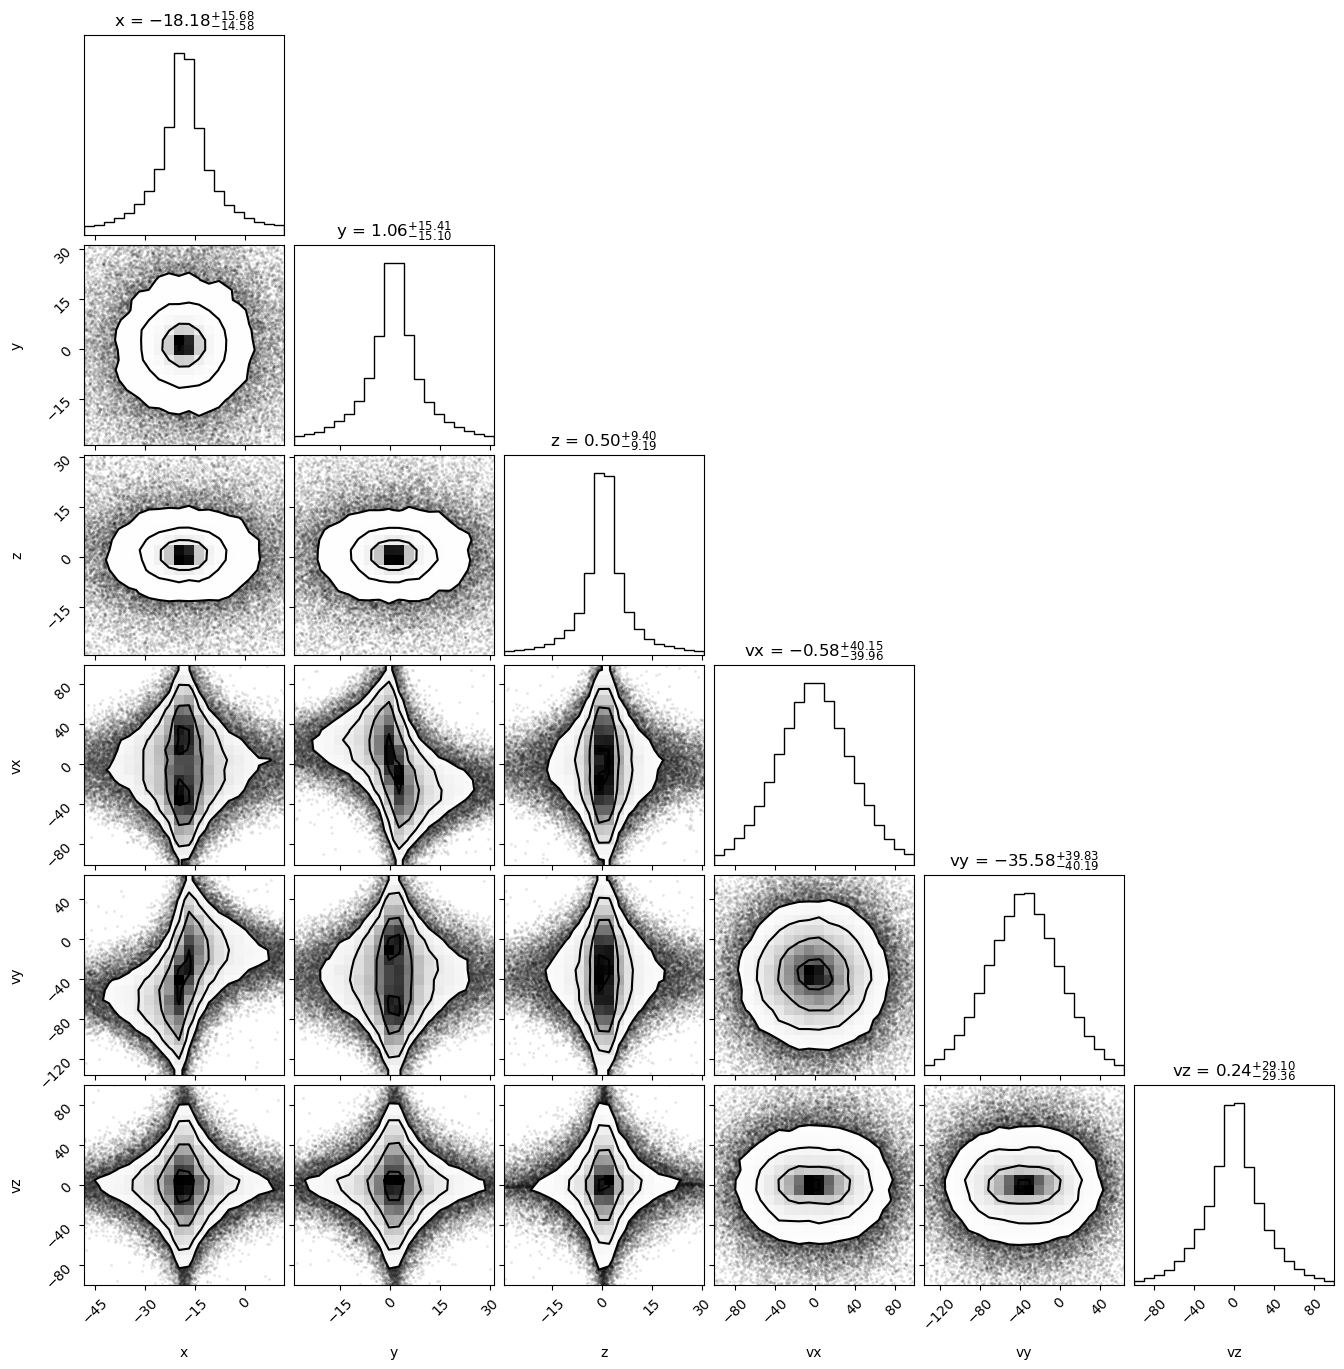

In [11]:
# corner figure of data set 

fig = corner.corner(df.loc[df.star==True][['x','y','z','vx','vy','vz']], range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Generate a new, synthetic dataset that follows the same underlying distibution as the original dataset:

In [12]:
# stack our original data into the format that is expected by gaussian_kde

orig_data = np.vstack([df['x'].values, df['y'].values, df['z'].values, df['vx'].values, df['vy'].values, df['vz'].values])

In [13]:
# create the kde. bw_method = .001 value selected for best fit by eye. 

kde = gaussian_kde(orig_data, bw_method = .0001)

In [14]:
#resample the kde to create the synthetic dataset 

new_data = kde.resample(size=len(df['x'].values))

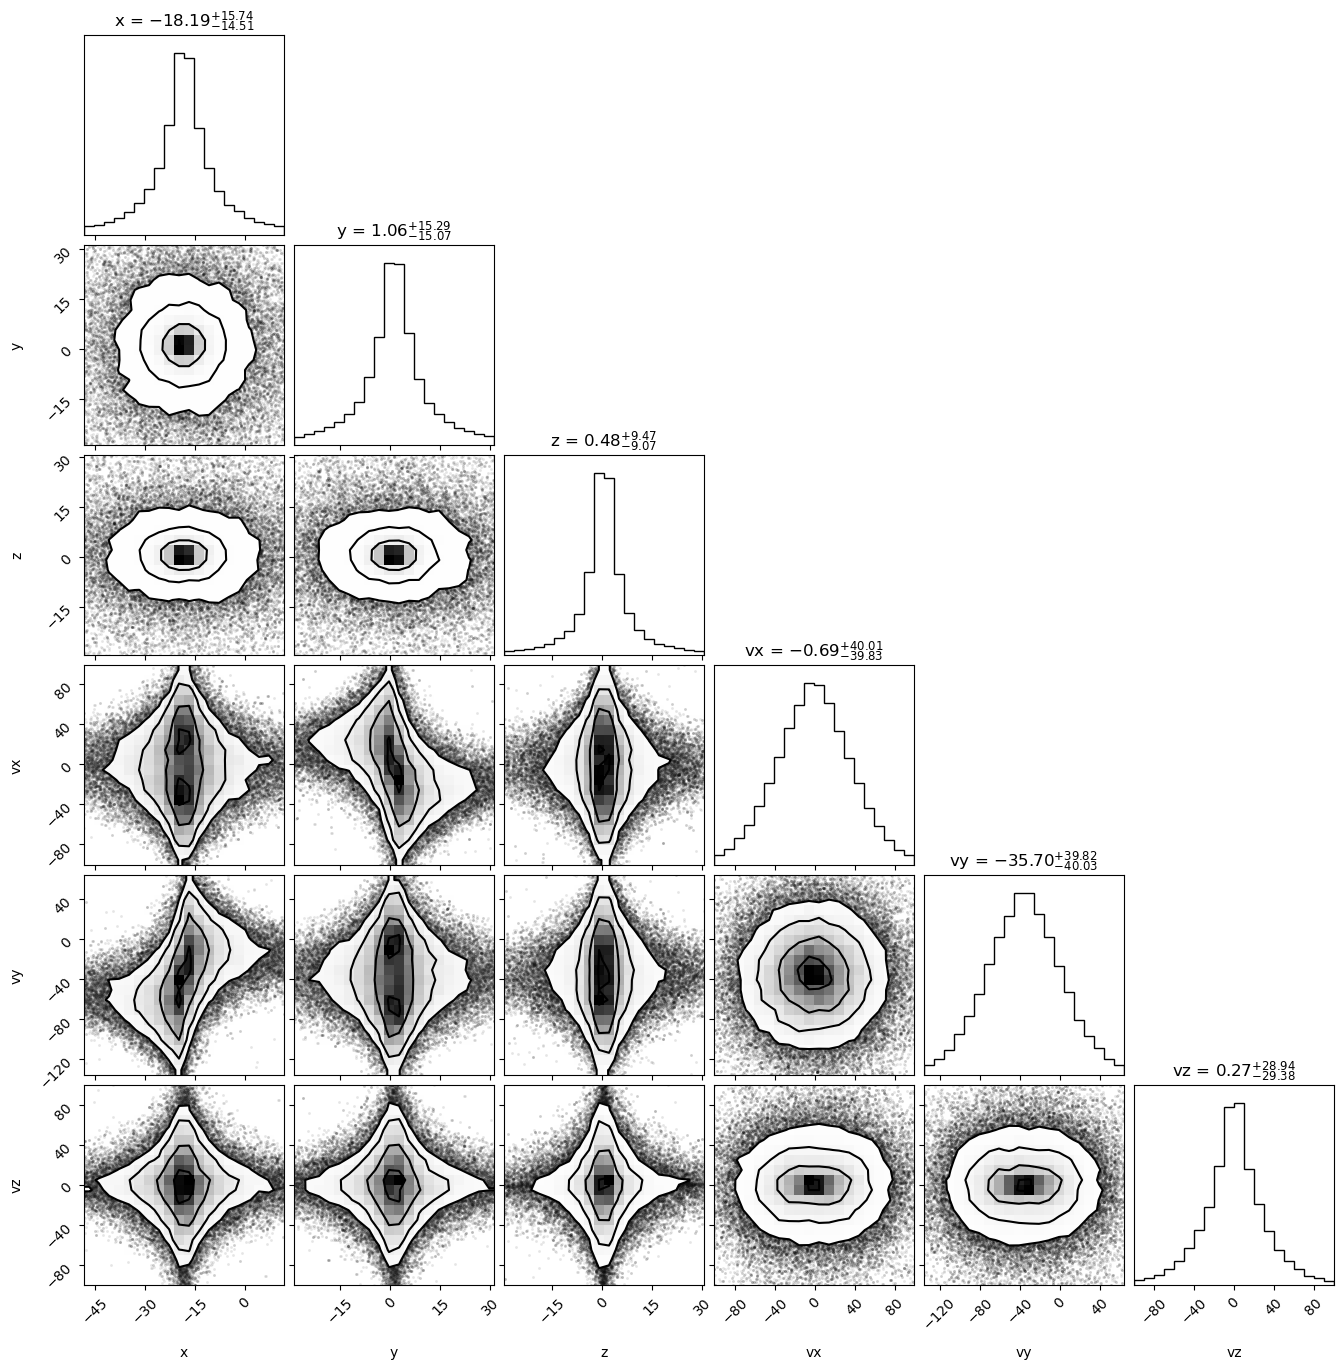

In [15]:
#corner plot using new synthetic data to mirror the one above 

fig = corner.corner(new_data.T, range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Determine and move to the black hole's center of mass (com) frame:

In [16]:
#data for the two black holes:
df_bh = df.loc[df["star"]==False].copy()
df_bh

,x,y,z,vx,vy,vz,m,r,v,star,nsc
0,-18.20694,1.048421,0.377924,-288.6334,93.93971,9.444297,1000000.0,18.241016,303.682570,False,1
65537,-18.21712,1.028614,0.377476,285.5273,-172.52600,-12.315550,1000000.0,18.250041,333.830395,False,2


In [17]:
#black holes masses are the same in this dataset, so could just take the average
#but coding the full com caclculation for using this code on a non-equal mass dataset

#also note that this is not the center of mass of the cluster, it is the center of mass of the two black holes
#see commmented code block below for center of mass of entire cluster

x_bh_com = (df_bh.x*df_bh.m).sum() / df_bh.m.sum() 
y_bh_com = (df_bh.y*df_bh.m).sum() / df_bh.m.sum()
z_bh_com = (df_bh.z*df_bh.m).sum() / df_bh.m.sum()

vx_bh_com = (df_bh.vx*df_bh.m).sum() / df_bh.m.sum() 
vy_bh_com = (df_bh.vy*df_bh.m).sum() / df_bh.m.sum()
vz_bh_com = (df_bh.vz*df_bh.m).sum() / df_bh.m.sum()

In [18]:
# #example code for center of mass of entire cluster or each individual cluster:

# #calculate the total center of mass:
# xcom = (df.x*df.m).sum() / df.m.sum()

# #center of mass of each cluster
# xcom1 = (df.loc[df['nsc'] == 1].x*df.loc[df['nsc'] == 1].m).sum() / df.loc[df['nsc'] == 1].m.sum()
# xcom2 = (df.loc[df['nsc'] == 2].x*df.loc[df['nsc'] == 2].m).sum() / df.loc[df['nsc'] == 2].m.sum()

In [19]:
#create a data frame moved the the black hole's center of mass frame

df_com = df.copy()
df_com['x'] = df_com['x'] - x_bh_com
df_com['y'] = df_com['y'] - y_bh_com
df_com['z'] = df_com['z'] - z_bh_com
df_com['vx'] = df_com['vx'] - vx_bh_com
df_com['vy'] = df_com['vy'] - vy_bh_com
df_com['vz'] = df_com['vz'] - vz_bh_com

df_com['r'] = (df_com.x**2 + df_com.y**2 + df_com.z**2)**(1/2)
df_com['v'] = (df_com.vx**2 + df_com.vy**2 + df_com.vz**2)**(1/2) 

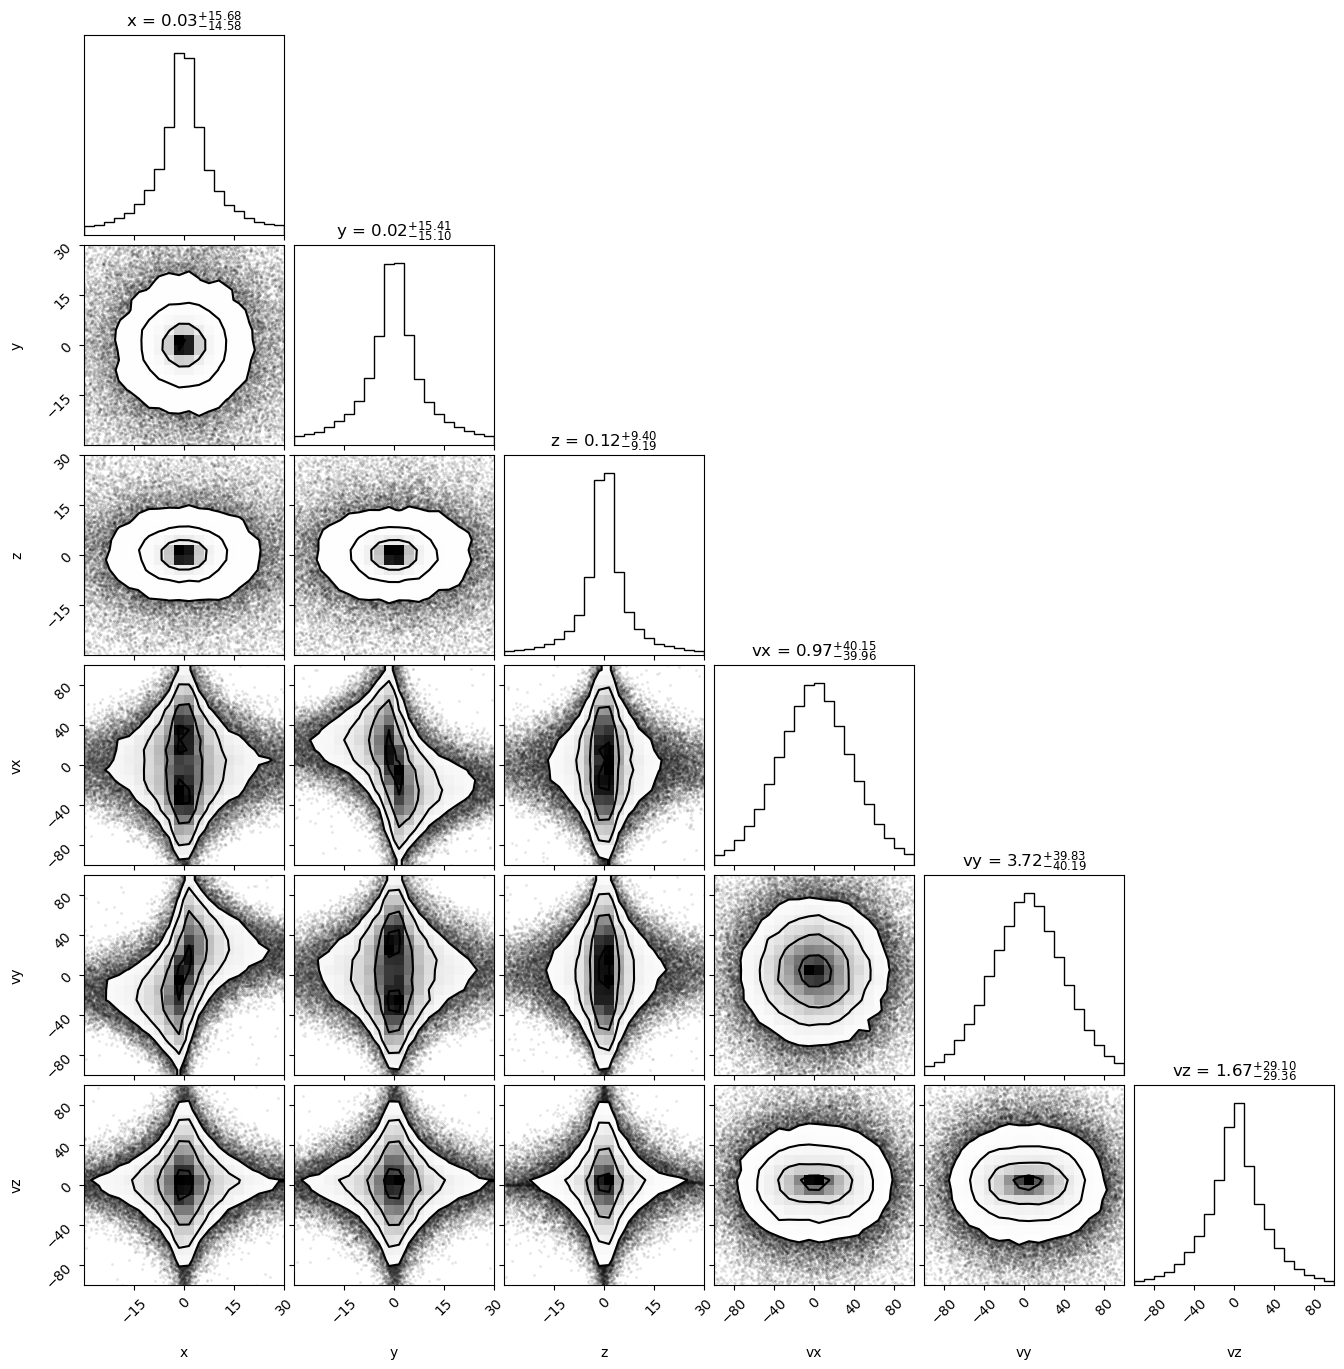

In [20]:
#new corner plot with com data
#note that median has been removed in range definition 

fig = corner.corner(df_com.loc[df_com.star==True][['x','y','z','vx','vy','vz']], range = [(-30,30),(-30,30), (-30,30), (-100,100), (-100,100), (-100,100)], labels=df_com.columns.tolist(), show_titles=True, title_fmt=".2f")


Determine density profile of cluster and make sure it reproduces results in __[Mastrobuono-Battisti et. al (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.6089M/abstract)__:

In [33]:
m_star = df.iloc[1].m
m_bh = df.iloc[0].m

In [34]:
r_smooth_lin = np.linspace(0.1, 100, 1000)
r_smooth_log = np.logspace(-1, 3, 1000)


In [35]:
density_r = []
for i, r in enumerate(r_smooth_log):
    dr = r_smooth_log[i]-r_smooth_log[i-1]
    volume = 4/3 *np.pi *r**3 - 4/3 *np.pi *(r-dr)**3
    N = len(df_com.loc[df_com.r < r]) - len(df_com.loc[df_com.r < (r-dr)])
    density_r.append(m_star *N/volume)

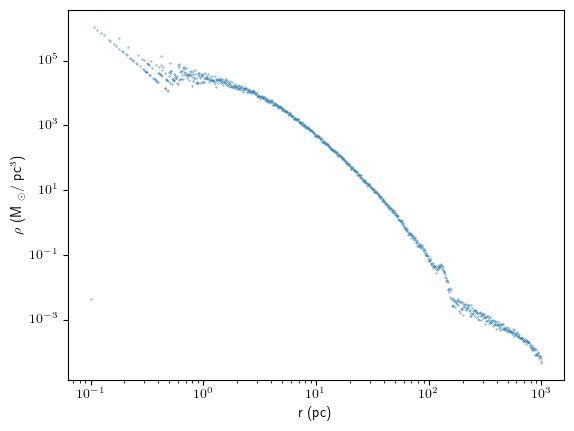

In [135]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$\\rho$ (M $_{\\odot}/$ pc$^3$)')
ax.set_xlabel('r (pc)')
ax.scatter(r_smooth_log, density_r, .1)

In [37]:
#cummulative mass distribution
mass_r = []
for r in r_smooth_lin:
    mass_r.append(m_star*len(df_com.loc[df_com.r < r]))

Text(0.5, 0, 'r (pc)')

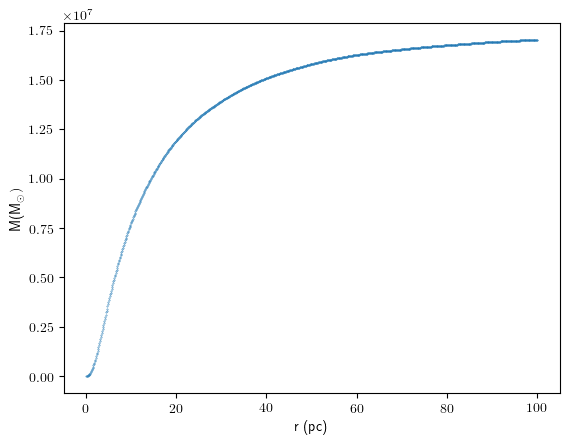

In [133]:
fig, ax = plt.subplots()
ax.scatter(r_smooth_lin, mass_r, .1)
ax.set_ylabel('M(M$_{\\odot})$')
ax.set_xlabel('r (pc)')

Caclulate Keplerian orbital elements from the cartesian coordinates and velocities

https://downloads.rene-schwarz.com/download/M002-Cartesian_State_Vectors_to_Keplerian_Orbit_Elements.pdf

In [21]:
# mks unit converstions factors

G = 6.674*10**-11 #Gravitational constant in mks                                                                                                                                                                          
kg_per_solar = 1.9891*10**30 #mass of sun in kg
m_per_pc = 3.086*10**16 #convert from parsec to meters

# asto unit converstion factor

G_astro =  4.3*10**-3 #Gravitational constant in (km/s)^2 pc Msun^-1

In [22]:
#new data frame in mks units - will add columns for Keplarian orbital elements 

df_mks = df_com.copy()

df_mks.x = df_mks.x * m_per_pc  #convert from pc to m
df_mks.y = df_mks.y * m_per_pc
df_mks.z = df_mks.z * m_per_pc
df_mks.r = df_mks.r * m_per_pc
df_mks.vx = df_mks.vx * 1000 #convert from km/s to m/s
df_mks.vy = df_mks.vy * 1000
df_mks.vz = df_mks.vz * 1000
df_mks.v = df_mks.v * 1000
df_mks.m = df_mks.m * kg_per_solar #convert from solar masses to kg

In [23]:
#graviational parameter mu = GM

mu = G* (df_mks.iloc[0].m + df_mks.iloc[iBH2].m)

In [24]:
r_array = df_mks[['x', 'y', 'z']].to_numpy() 
v_array = df_mks[['vx', 'vy', 'vz']].to_numpy()

In [25]:
#specific angular momentum 
h_array = np.cross(r_array, v_array)

In [26]:
#eccentricity vector 
e_array = np.cross(v_array, h_array)/mu - r_array/(df_com.r.values[:, np.newaxis]*m_per_pc)

In [27]:
e_array

array([[-0.40234544, -0.77163114, -0.01731775],
       [ 0.73151095, -0.89850097,  0.72131811],
       [ 0.48826671,  0.34737513,  0.11708814],
       ...,
       [ 2.73431234,  1.67807661, -2.53384388],
       [-3.49339281, -0.46366491,  7.03008293],
       [ 0.046171  ,  3.24910189, -0.17080306]])